# Polscope with phase reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftn, ifftn, fftshift, ifftshift

import pickle
import waveorder as wo

import time

%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Load data

In [2]:
# Load simulations


file_name = 'uPTI_simulation_data_NA_det_147_NA_illu_140_2D_spoke_discrete_no_1528_ne_1553_no_noise_Born.npz'

array_loaded = np.load(file_name)
list_of_array_names = sorted(array_loaded)

for array_name in list_of_array_names:
    globals()[array_name] = array_loaded[array_name]

print(list_of_array_names)

I_meas = np.transpose(I_meas[:,:,:,:,50],(0,2,3,1))
z_defocus = np.array([0])

I_meas = I_meas[1:]
I_meas.shape


['I_meas', 'NA_illu', 'NA_obj', 'Source_PolState', 'Source_cont', 'chi', 'lambda_illu', 'n_media', 'ps', 'psz', 'z_defocus']


(4, 200, 200, 9)

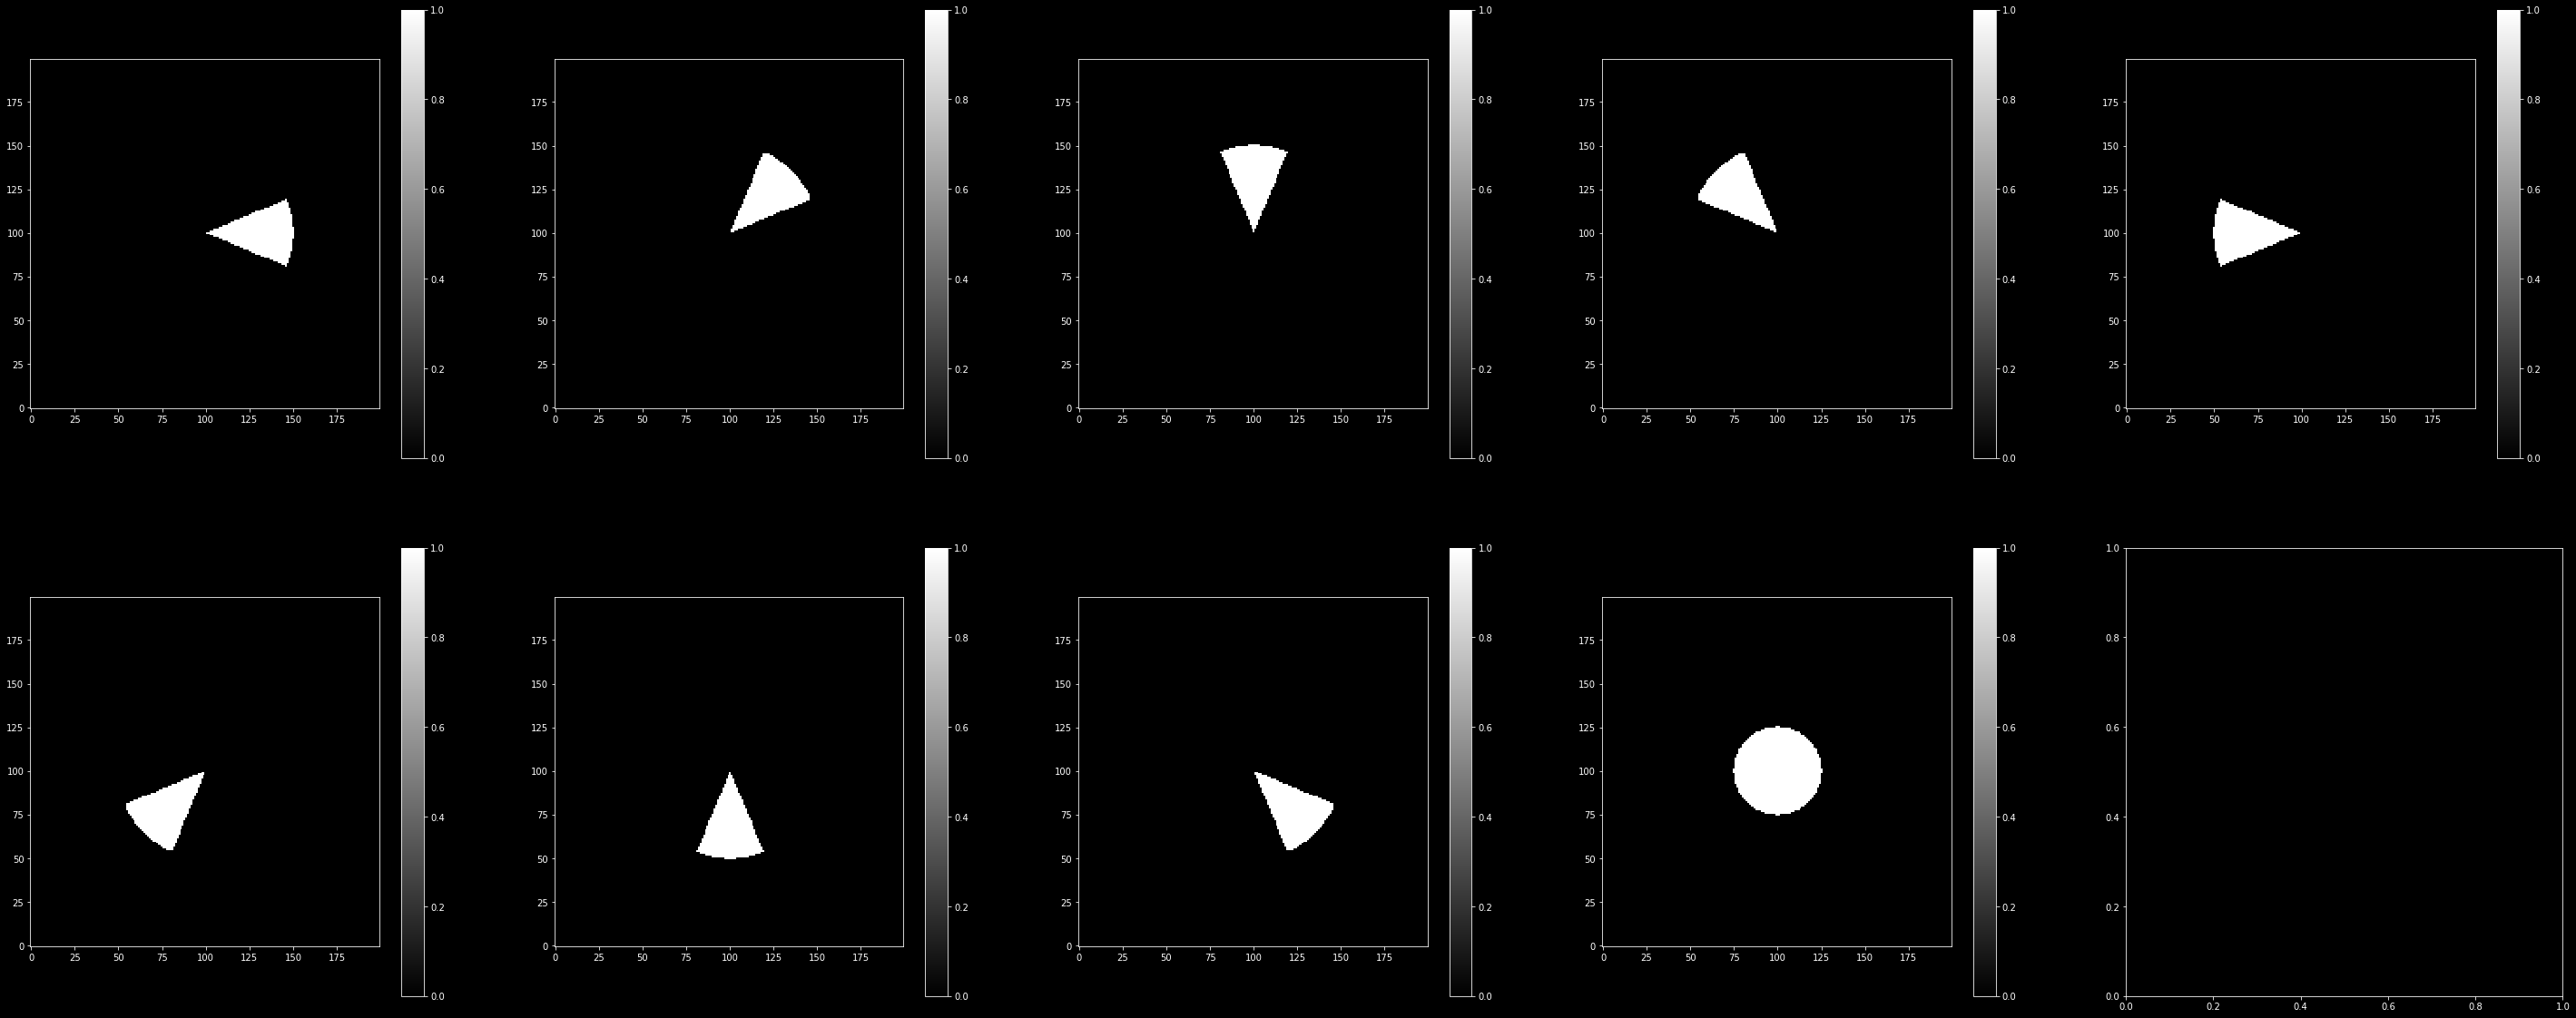

In [3]:
# illumination patterns used
wo.plot_multicolumn(fftshift(Source_cont,axes=(1,2)), origin='lower', num_col=5)

### Initiate the reconstruction


In [5]:
_, N, M, _ = I_meas.shape
cali        = False               
bg_option   = 'global'            
use_gpu = True
gpu_id = 1

# chi = pi/2

A_matrix = 0.5*np.array([[1, 1, 0], \
                         [1, 0, 1], \
                         [1, -1, 0], \
                         [1, 0, -1]])


setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media=n_media, cali=cali, phase_deconv='2D', \
                                A_matrix=A_matrix, inc_recon='2D-vec-WOTF', \
                                illu_mode='Arbitrary', Source = Source_cont, Source_PolState=Source_PolState, \
                                use_gpu=use_gpu, gpu_id=gpu_id)


### Browsing high-dimensional data


In [8]:
S_image_recon = setup.Stokes_recon(I_meas)

S_image_tm = np.zeros_like(S_image_recon)

S_bg_mean_0 = np.mean(S_image_recon[0,:,:,:], axis=(0,1))[np.newaxis,np.newaxis,:]
S_bg_mean_1 = np.mean(S_image_recon[1,:,:,:], axis=(0,1))[np.newaxis,np.newaxis,:]
S_bg_mean_2 = np.mean(S_image_recon[2,:,:,:], axis=(0,1))[np.newaxis,np.newaxis,:]


S_image_tm[0] = S_image_recon[0]/S_bg_mean_0-1
S_image_tm[1] = S_image_recon[1]/S_bg_mean_0 - S_bg_mean_1*S_image_recon[0]/S_bg_mean_0**2
S_image_tm[2] = S_image_recon[2]/S_bg_mean_0 - S_bg_mean_2*S_image_recon[0]/S_bg_mean_0**2




In [11]:
wo.parallel_4D_viewer(np.transpose(S_image_recon,(3,0,1,2)), num_col=4, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [13]:
wo.parallel_4D_viewer(np.transpose(S_image_tm,(3,0,1,2)), num_col=4, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### 2D uPTI reconstruction

In [14]:
reg_inc = np.array([1, 1, 1, 1, 1, 1, 1])*1e-1

reg_ret_pr = 1e-2

f_tensor = setup.scattering_potential_tensor_recon_2D_vec(S_image_tm, reg_inc=reg_inc)

Finished preprocess, elapsed time: 0.11
Finished reconstruction, elapsed time: 4.34


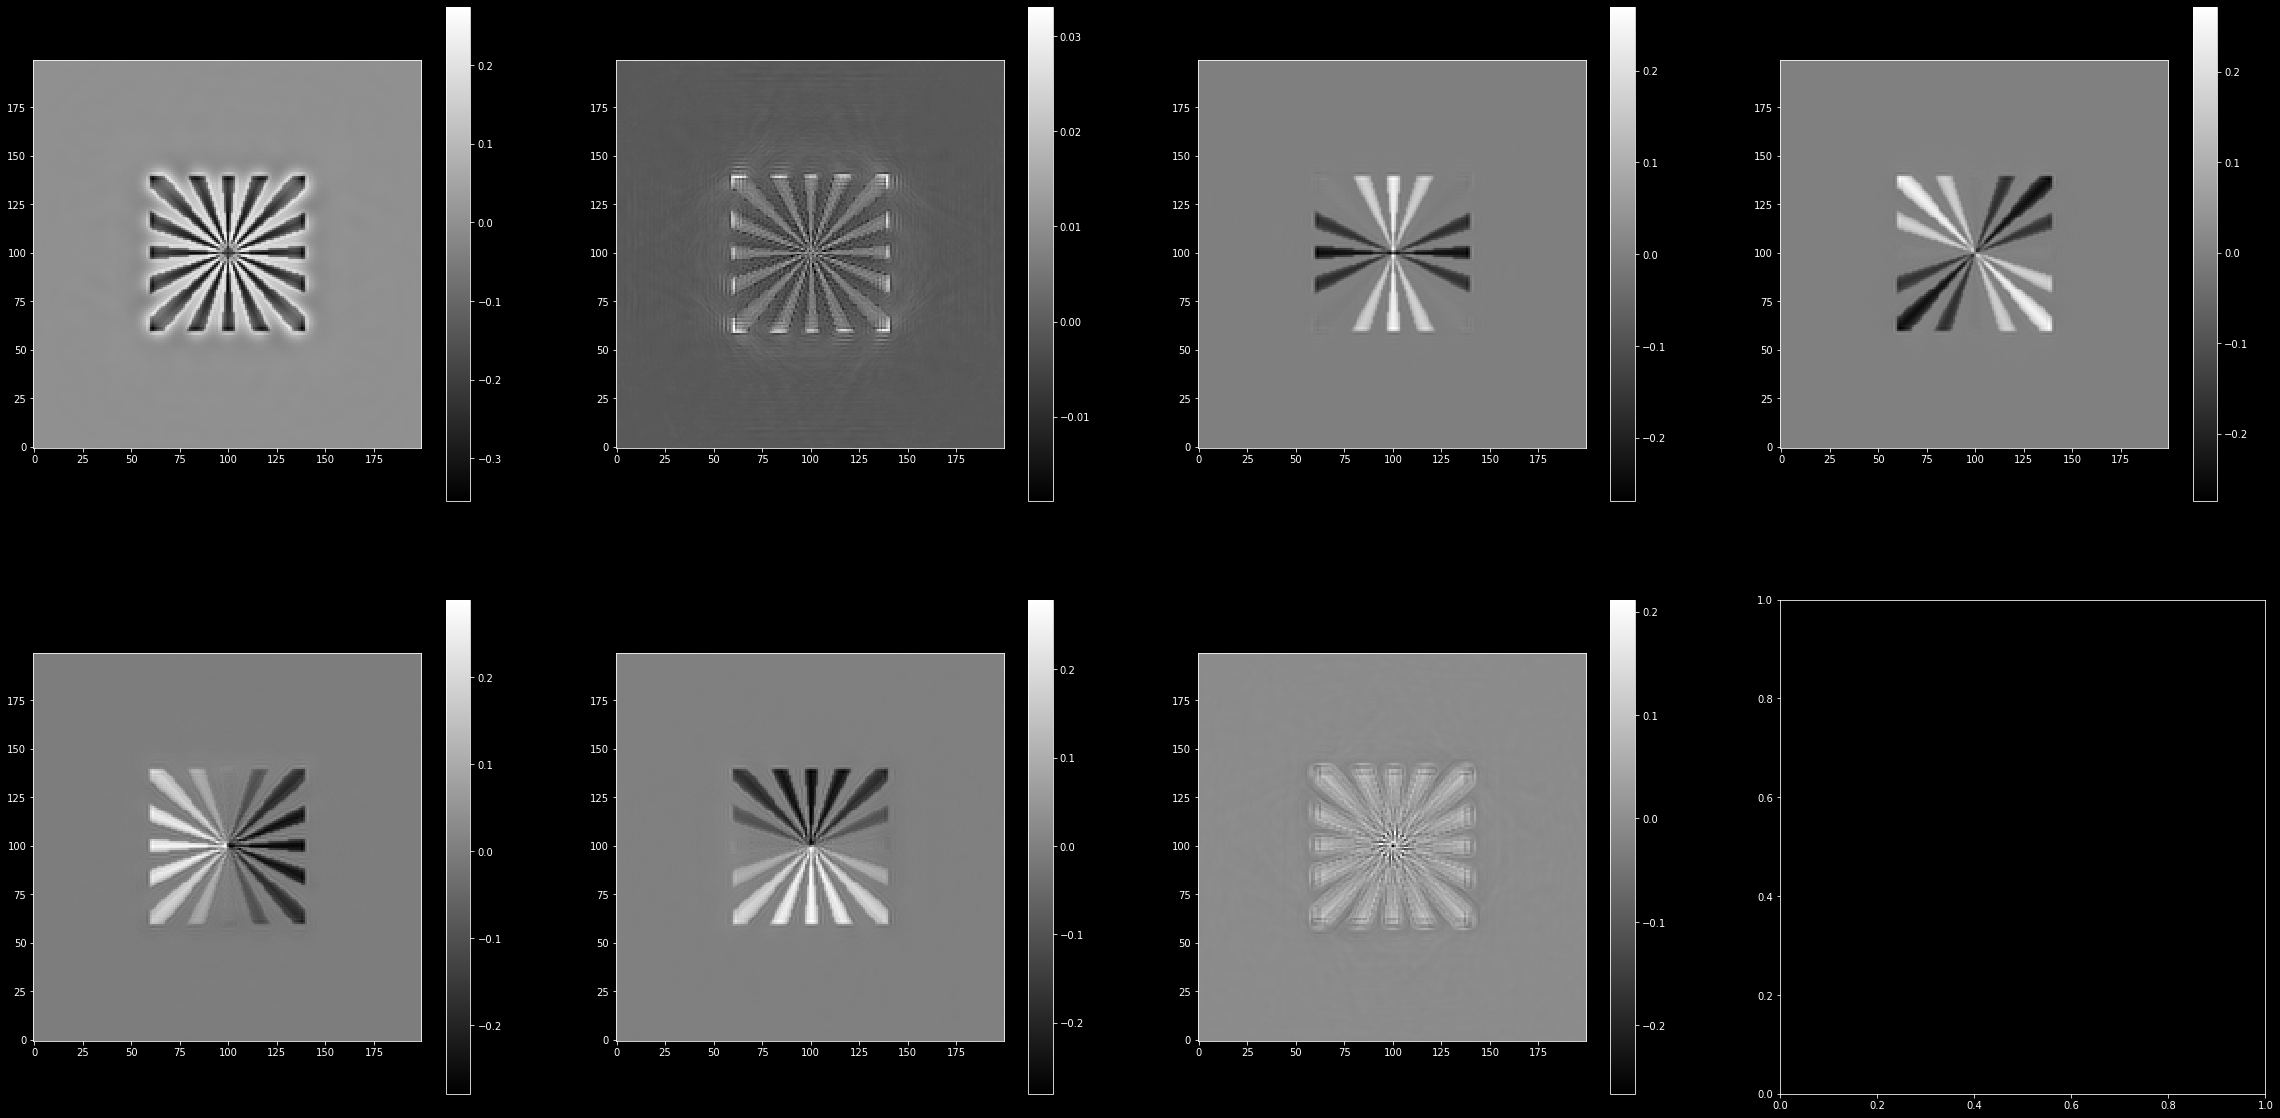

In [15]:
wo.plot_multicolumn(f_tensor, num_col=4, origin='lower')

Finish optic sign estimation, elapsed time: 15.92


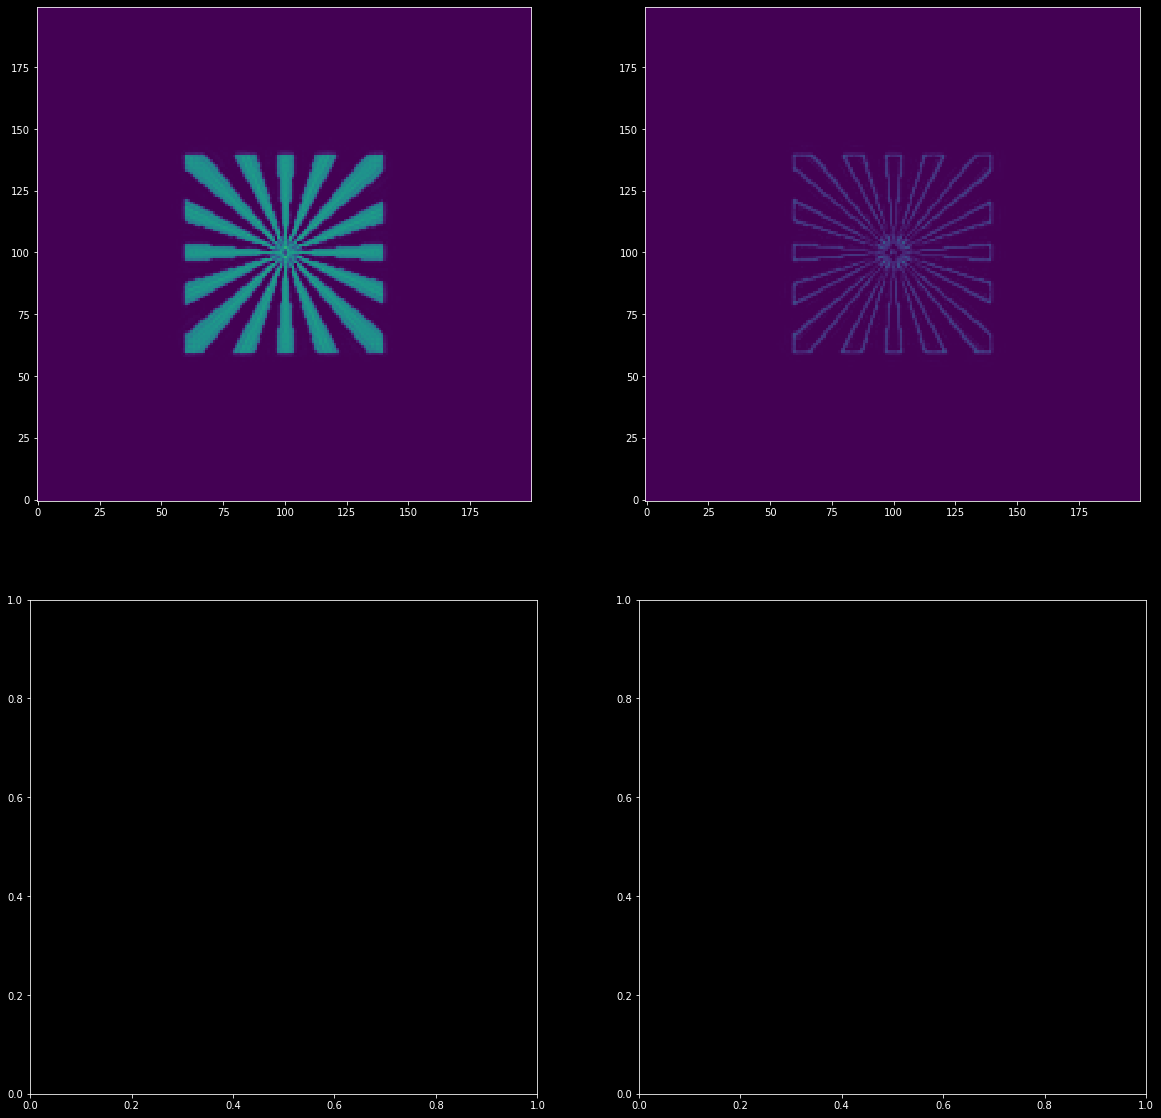

In [16]:
retardance_pr, azimuth, theta, mat_map = setup.scattering_potential_tensor_to_3D_orientation(f_tensor, S_image_tm,\
                                                                                             material_type='unknown', reg_ret_pr = reg_ret_pr, itr=20, step_size=0.1)

In [17]:
# clean up GPU memory leftorver

import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [18]:
# scaling to the physical properties of the material

# optic sign probability
mat_map_thres = 0.1
mat_map_norm = mat_map / np.max(np.abs(np.sum(mat_map,axis=0)))
p_mat_map = np.maximum(mat_map_norm[0],mat_map_thres)/(np.maximum(mat_map_norm[0],mat_map_thres) + np.maximum(mat_map_norm[1],mat_map_thres))

# absorption and phase
absorption = f_tensor[1]/(4*np.pi/lambda_illu*n_media)
phase = -f_tensor[0]/(4*np.pi/lambda_illu*n_media)

# principal retardance (with some wavelet denoising)
retardance_pr_nm = retardance_pr/(2*np.pi/lambda_illu*n_media)/2/np.pi*lambda_illu*1e3



### Visualization of 3D reconstruction

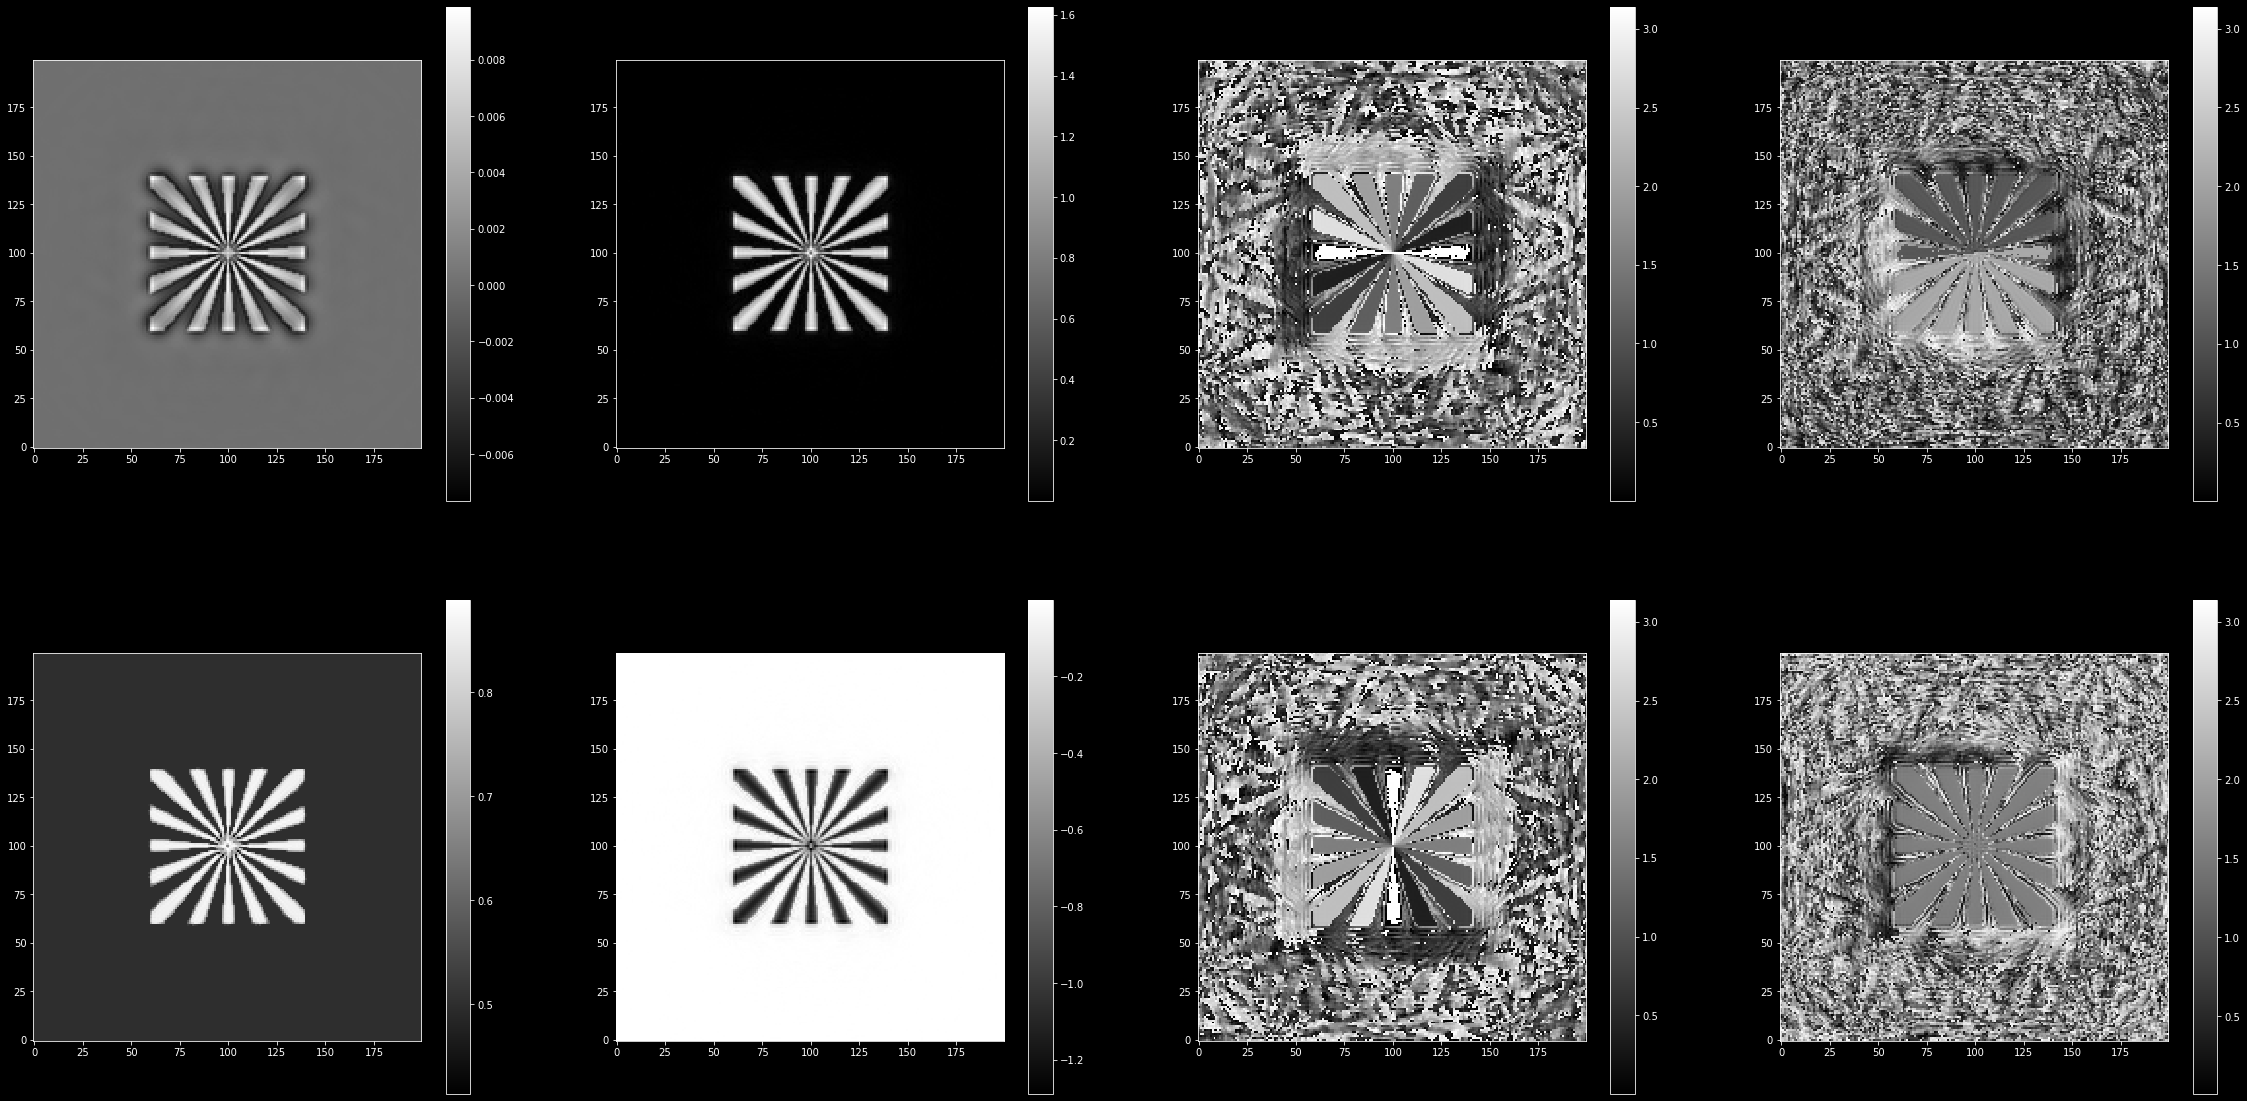

In [19]:
wo.plot_multicolumn([phase, retardance_pr_nm[0], azimuth[0], theta[0], \
                     p_mat_map, retardance_pr_nm[1], azimuth[1], theta[1]], num_col=4, origin='lower')

In [23]:
ret_min_color = 0
ret_max_color = 1.5

orientation_3D_image = np.transpose(np.array([azimuth[0]/2/np.pi, theta[0], (np.clip(np.abs(retardance_pr_nm[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]),(1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


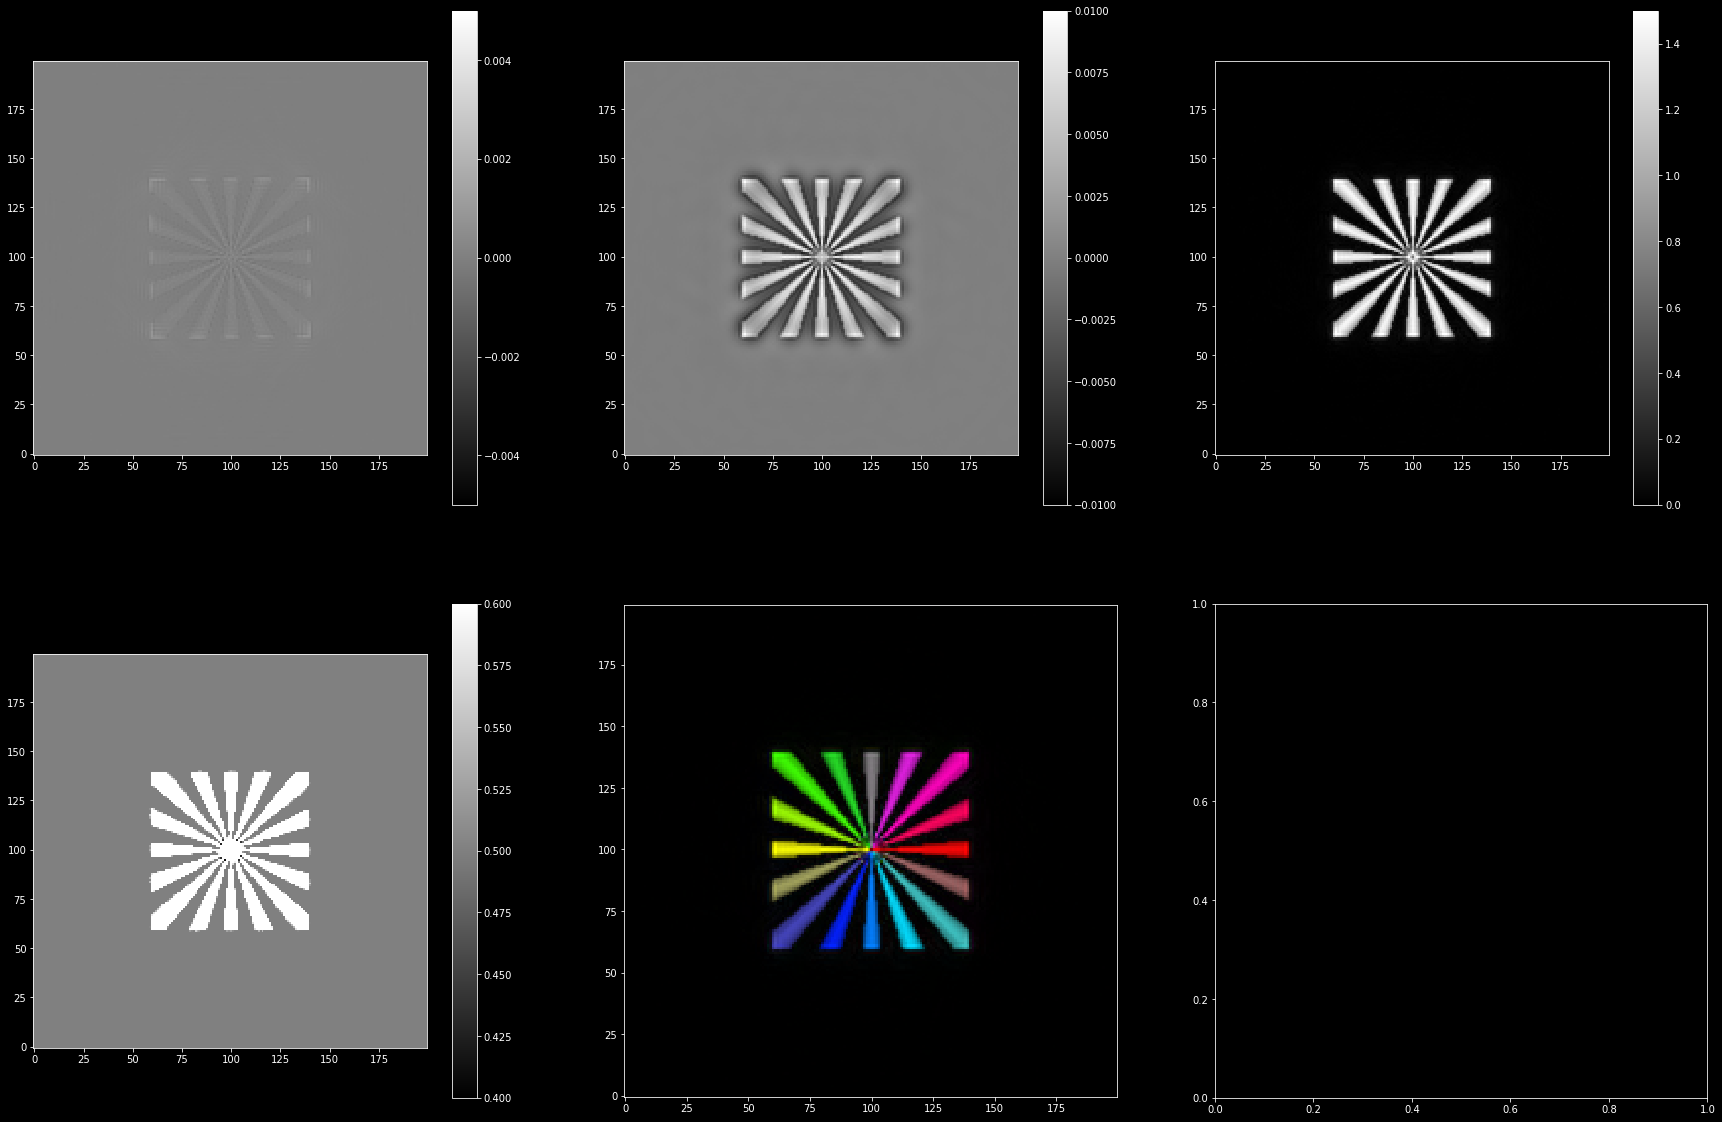

In [24]:
abs_min = -0.005
abs_max = 0.005
phase_min = -0.01
phase_max = 0.01
ret_min = 0
ret_max = 1.5
p_min = 0.4
p_max = 0.6


fig,ax = plt.subplots(2,3,figsize=(30,20))

sub_ax = ax[0,0].imshow(absorption, cmap='gray', origin='lower', vmin=abs_min, vmax=abs_max)
plt.colorbar(sub_ax, ax=ax[0,0])

sub_ax = ax[0,1].imshow(phase, cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
plt.colorbar(sub_ax, ax=ax[0,1])

sub_ax = ax[0,2].imshow(np.abs(retardance_pr_nm[0]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
plt.colorbar(sub_ax, ax=ax[0,2])
sub_ax = ax[1,0].imshow(p_mat_map, cmap='gray', origin='lower',vmin=p_min, vmax=p_max)
plt.colorbar(sub_ax, ax=ax[1,0])

sub_ax = ax[1,1].imshow(orientation_3D_image_RGB, origin='lower')
# plt.colorbar(sub_ax, ax=ax[1,1])


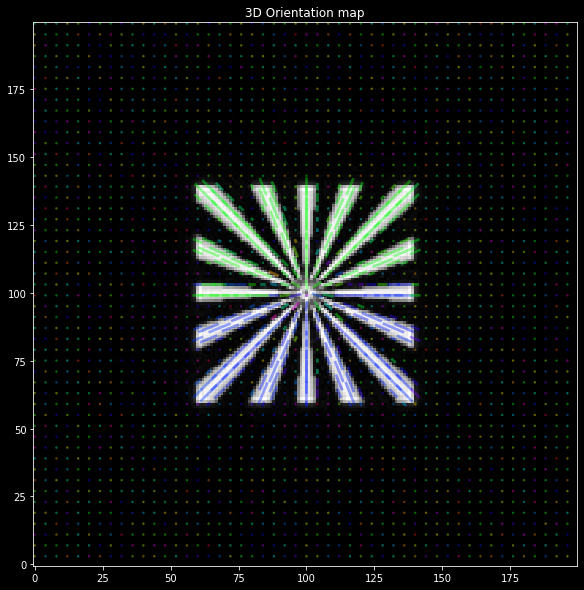

In [27]:

spacing = 4


# plt.figure(figsize=(10,10))

fig,ax = plt.subplots(1,1,figsize=(20,10))
wo.plot3DVectorField(np.abs(retardance_pr_nm[0]), azimuth[0], theta[0], 
                     anisotropy=0.4*np.abs(retardance_pr_nm[0]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=spacing, linelength=spacing, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax)



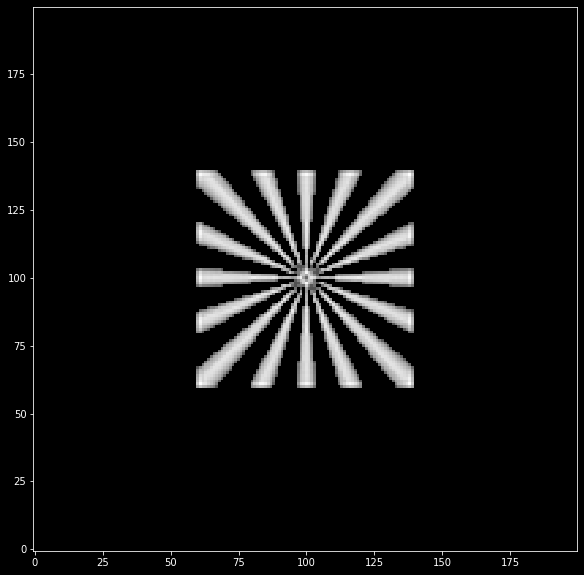

In [29]:
ret_mask = np.abs(retardance_pr_nm[0]).copy()
ret_mask[ret_mask<0.5]=0
# ret_mask[:,:,:50]=0

plt.figure(figsize=(10,10))
plt.imshow(ret_mask, cmap='gray', origin='lower')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7ffcc07ca1d0>)

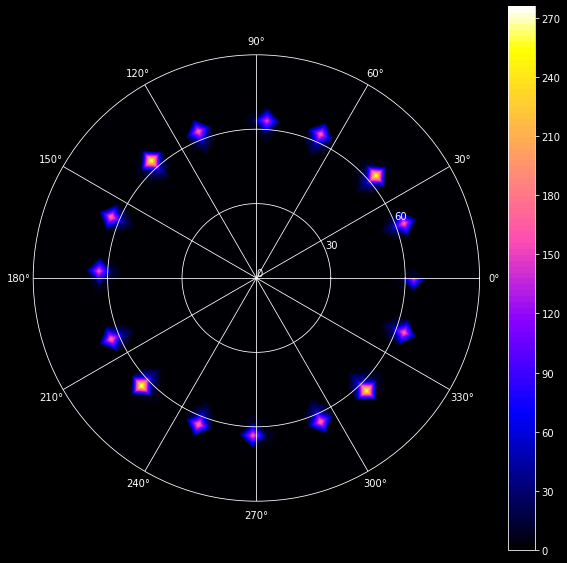

In [30]:
# Angular histogram of 3D orientation

wo.orientation_3D_hist(azimuth[0].flatten(), \
                       theta[0].flatten(), \
                       ret_mask.flatten(),\
                       bins=36, num_col=1, size=10, contour_level = 100, hist_cmap='gnuplot2', top_hemi=True)

In [31]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()